In [37]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'brats2020-training-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F723383%2F1267593%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240222%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240222T180727Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D166618f79e892c1e2d29a554e4c5fd72332452a1dd8244d01e08f2da2ff5f01aa4ca7263be70674befa19a298779379295a43f004f15284a4a1f7cfafed937acfd22a8f7dca4bd904841b30085ebfdb4c78112a2eaa26339f709dc52c74e468bfee57609a5de3f6bc630e3355995be1e6bd97b978dff02cc84c548c6b8963f840cb7f8ba136721923a1acdffd823db6e84e54e8a77e5c2cd79c82cd0819c5f1ea9fefb0276fbc85f3214709c96166c28d9b4037efd79f539f8ca323c328b8c2c0e20b2a034c7a99c9d8b89ec977056ec9abcd4f83b4bc644a186f73b214a2d4ab9031096bc35374ce564eaea1b9d70f92ace29f0cc1763fe583e5a2c16bef845,brats20-dataset-training-validation:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F751906%2F1299795%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240222%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240222T180727Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da800fbc90c95e47b9fdebf4f9a7125a91a144ad8198b04e5df40545849af9a7cc276639162b89aa5077a472db727bdc50aa2eb4a158b745287101483fea5941ed8a088dd77f35725bdf58df4086d522ff7cf805e34d5fb3a62d9609d56d70385dc0db2fda4d7db169514a2cc12053caf2040afce3f84a6360940633b67168ec6b7e153fefdd321dd72486044471162d9e405fe3d46d6035e3612cbd95d4f69e3ad6a4edede2f218efb3f6d5b334886d7deb81ab34364033b4757a9531ffb6a085589349172f3c734532c4a9966151bdfc07bc661e5eaa22252ac6bad8e941e9ac64208a71d12f287f1a45a4c43eaddff90cebacd044301cda0b438576e90d01b,cse676-brats-semantic-segmentation:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2202256%2F3679979%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240222%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240222T180727Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da281c6826dde65c2b08169deadb330b75a449f8eb4ab31c19c233bcfc0753c105459e44632c7f238b2c1806794a630d991aae8be454498c096d866b7ae9a87ae5e903f83c668ae109b41ee5c01a3ec54d632305395d1501e1b26a2b7c8634d7676d6731ee7fee363ac43617e9b1cc9ee8034967b3010ea101b06090eaacb4812c039657bc822b0cb2ffe39e7c844ac3691cf6e7d76a11bd1e937c7b06c94dc6f1ab2b3bf5b227e43252520f71a5d3793dce835083eff9e4c911ed0b92275be40aef872ce3c47b5b6f3e370100f75906774688d77b2b29df5efef1904a9ae691f616ed3cdad702a9daa816f8b970e823f47c5de6a8eced3d02f34dfd4bdbedbbc'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 7254224710 bytes downloaded
Downloaded and uncompressed: brats2020-training-data
[==================================================] 4468570941 bytes downloaded
Downloaded and uncompressed: brats20-dataset-training-validation
[==================================================] 1098606761 bytes downloaded
Downloaded and uncompressed: cse676-brats-semantic-segmentation
Data source import complete.


In [38]:
# First, Import all required Data,(MANDATORY)
# import data by URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
# import data by URL: https://www.kaggle.com/datasets/atulsingh1996/cse676-brats-semantic-segmentation

#ONLY EDIT THIS SECTION - BEGIN

# MODE can be 'TRAIN_FRESH' or 'EVALUATE'
# To do fresh training followed by its evaluation, Set to TRAIN_FRESH
# To only evaluate our pre-trained model, Set to EVALUATE
MODE = 'TRAIN_FRESH'

# This is the model architecture you want to train or test. It can only take the following values.
#'simpleUNET', 'resNETUNET', 'WNET', 'UNETVAE', 'VGG19', 'InceptionV3', 'InceptionResNetV2'
CURRENT_MODEL = 'VGG19'


#ONLY EDIT THIS SECTION - END

In [39]:
!pip install segmentation-models
!pip install nilearn

In [40]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 7.34.0
ipykernel        : 5.5.6
ipywidgets       : 7.7.1
jupyter_client   : 6.1.12
jupyter_core     : 5.7.1
jupyter_server   : 1.24.0
jupyterlab       : not installed
nbclient         : 0.9.0
nbconvert        : 6.5.4
nbformat         : 5.9.2
notebook         : 6.5.5
qtconsole        : not installed
traitlets        : 5.7.1


In [41]:
import nilearn
import nibabel as nib
import nilearn.plotting as nlplt

In [43]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
from skimage.transform import rotate
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import random
import pandas as pd

# Keras
import tensorflow as tf
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers.experimental import preprocessing

np.set_printoptions(precision=3, suppress=True)

In [44]:
TRAINING_DATASET = "../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*"

IMAGE_DIR = glob.glob(TRAINING_DATASET)
CSV_LIST = glob.glob(TRAINING_DATASET + 'csv')
for i in CSV_LIST:
    IMAGE_DIR.remove(i)

IMAGE_DIR.remove(TRAINING_DATASET.replace("*", "") + 'BraTS20_Training_355')
IMAGE_DIR = IMAGE_DIR[0:100]

TRAIN_LIST, VAL_LIST = train_test_split(IMAGE_DIR, test_size=0.2)
TRAIN_LIST, TEST_LIST = train_test_split(TRAIN_LIST, test_size=0.3)

VIEW_IMG_IDX = random.randint(0, len(TRAIN_LIST) - 1)
LIST_DATA = sorted(glob.glob(TRAIN_LIST[VIEW_IMG_IDX] + '/*'))
VIEW_IMAGE = {
    'flair': nib.load(LIST_DATA[0]).get_fdata(),
    't1': nib.load(LIST_DATA[2]).get_fdata(),
    't1ce': nib.load(LIST_DATA[3]).get_fdata(),
    't2': nib.load(LIST_DATA[4]).get_fdata(),
    'mask': nib.load(LIST_DATA[1]).get_fdata()
}

MODEL = {
    'simpleUNET': 'simpleUNET.h5',
    'resNETUNET': 'resnetUNET.h5',
    'WNET': 'WNET.h5',
    'UNETVAE': 'UNETVAE.h5',
    'VGG19': 'VGG19.h5',
    'InceptionV3': 'InceptionV3.h5',
    'InceptionResNetV2': 'InceptionResNetV2.h5'
}
LOG = {
    'simpleUNET': 'simpleUNET_training.log',
    'resNETUNET': 'resnetUNET_training.log',
    'WNET': 'WNET_training.log',
    'UNETVAE': 'UNETVAE_training.log',
    'VGG19': 'VGG19_training.log',
    'InceptionV3': 'InceptionV3_training.log',
    'InceptionResNetV2': 'InceptionResnetV2_training.log'
}

SEGMENT_CLASSES = {
    0: 'NOT tumor',
    1: 'NECROTIC/CORE',
    2: 'EDEMA',
    3: 'ENHANCING'
}
SAVED_MODEL = {
    'WNET': '../input/wnetmodel/WNET.h5',
    'resNETUNET': '../input/resnet-unet-trained-model/resnetUNET.h5',
    'simpleUNET': '../input/simpleunet/simpleUNet.h5',
    'VGG19': '../input/vgg19v2/VGG19.h5',
    'InceptionV3': '../input/inceptionv3/InceptionV3.h5',
    'InceptionResNetV2': '../input/inceptionresnetv2/InceptionResNetV2.h5'
}
SLICES_VOL = 100
VOL_START = 22
IMG_SIZE = 128

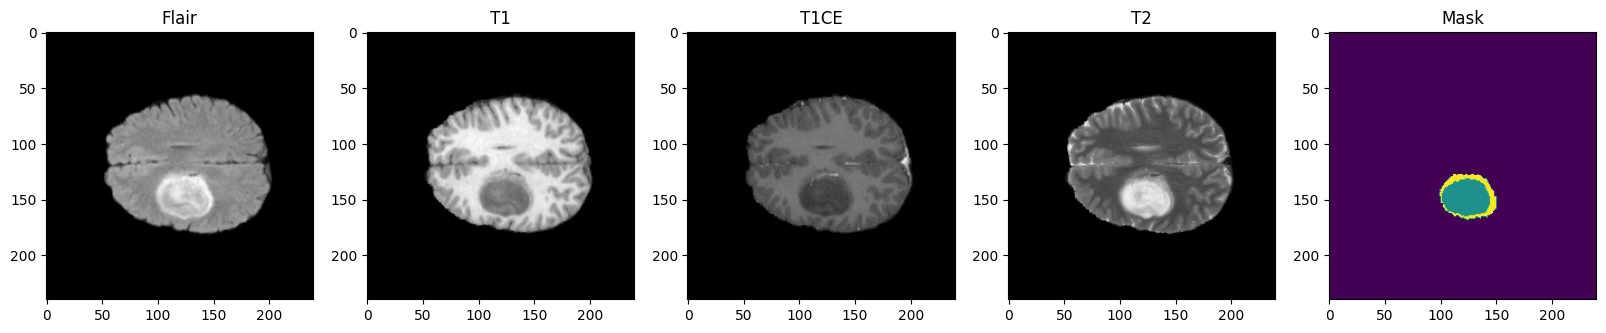

In [45]:
def analyse_initial_data():
    fig, (axis1, axis2, axis3, axis4, axis5) = plt.subplots(1, 5, figsize=(20, 10))
    slice_w = 25
    axis1.imshow(VIEW_IMAGE['flair'][:, :,
               VIEW_IMAGE['flair'].shape[0]//2 - slice_w], cmap='gray')
    axis1.set_title('Flair')
    axis2.imshow(
        VIEW_IMAGE['t1'][:, :, VIEW_IMAGE['t1'].shape[0]//2 - slice_w], cmap='gray')
    axis2.set_title('T1')
    axis3.imshow(
        VIEW_IMAGE['t1ce'][:, :, VIEW_IMAGE['t1ce'].shape[0]//2 - slice_w], cmap='gray')
    axis3.set_title('T1CE')
    axis4.imshow(
        VIEW_IMAGE['t2'][:, :, VIEW_IMAGE['t2'].shape[0]//2 - slice_w], cmap='gray')
    axis4.set_title('T2')
    axis5.imshow(VIEW_IMAGE['mask']
               [:, :, VIEW_IMAGE['mask'].shape[0]//2 - slice_w])
    axis5.set_title('Mask')


analyse_initial_data()

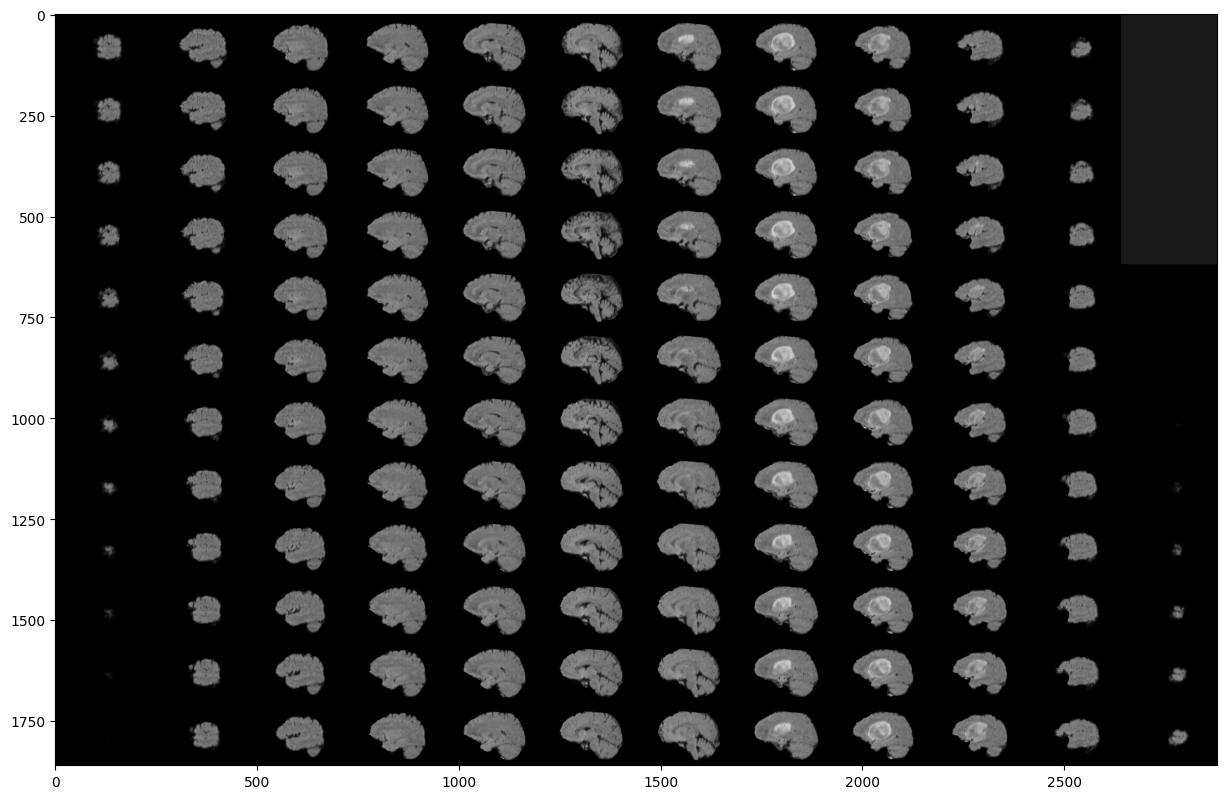

In [46]:
def show_montage():
    fig, axis = plt.subplots(1, 1, figsize=(15, 15))
    axis.imshow(rotate(
        montage(VIEW_IMAGE['flair'][50:-50, :, :]), 90, resize=True), cmap='gray')


show_montage()

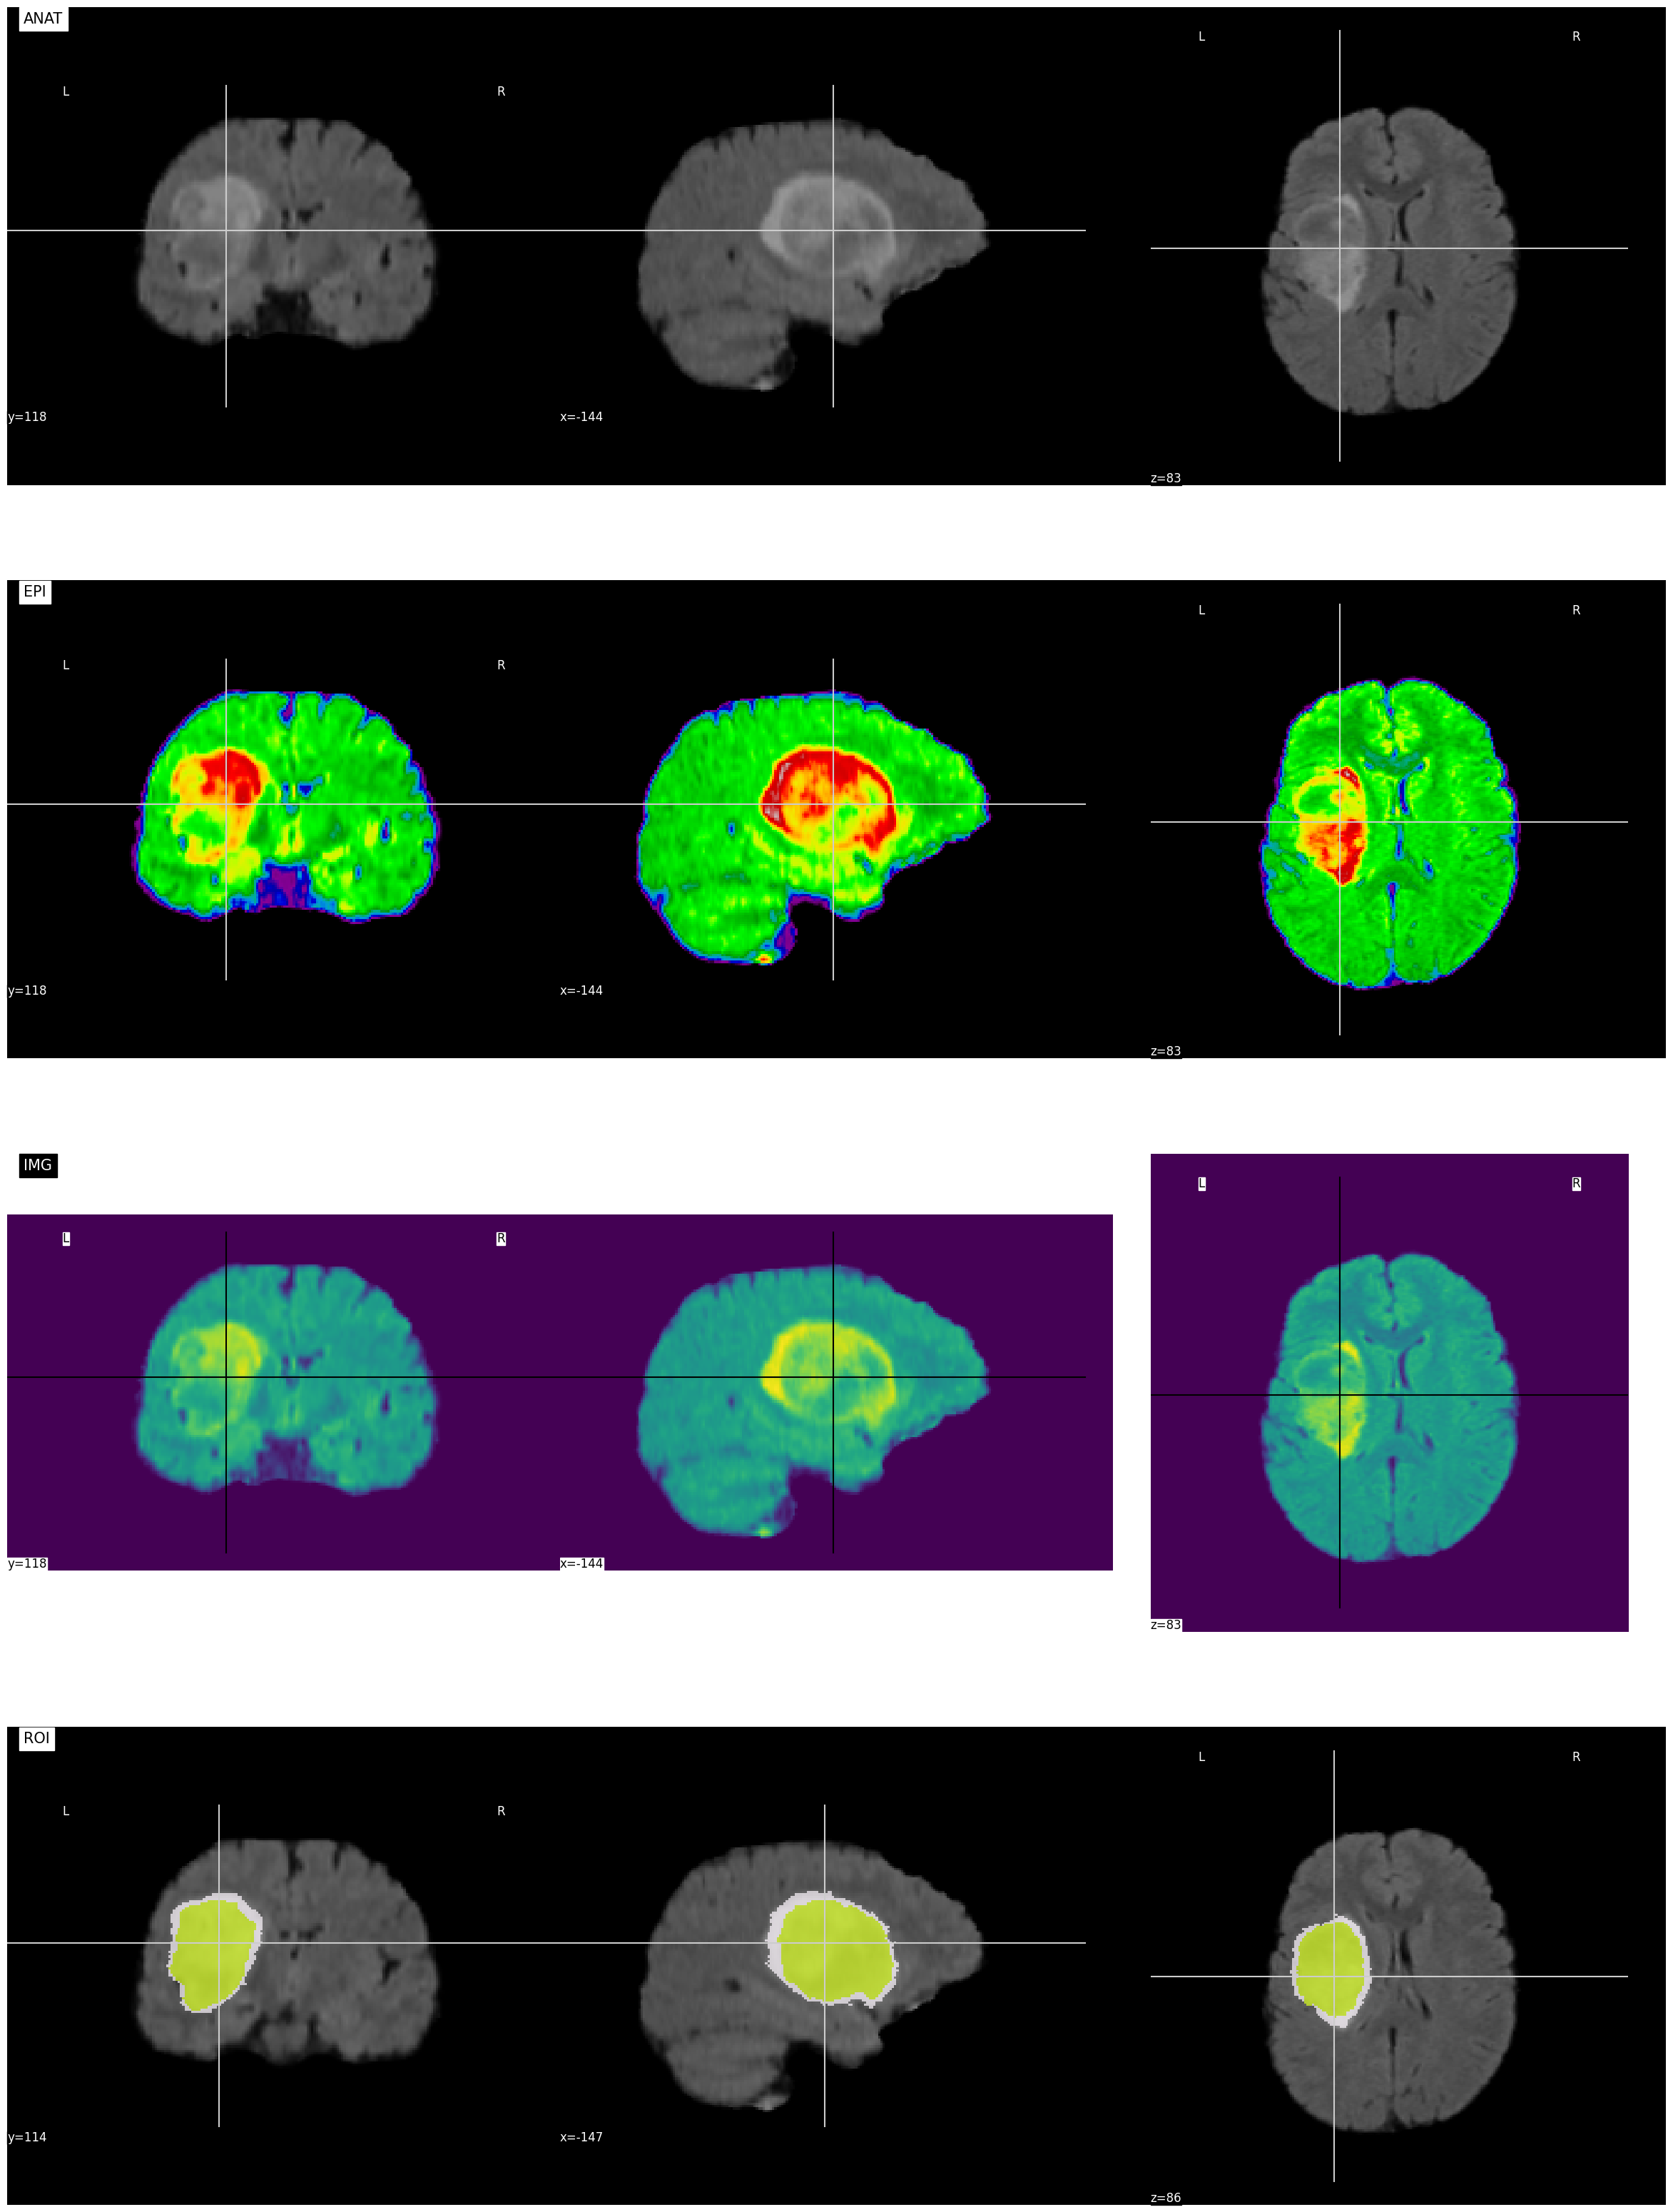

In [47]:
def show_mri_diagram():
    image = nilearn.image.load_img(LIST_DATA[0])
    mask = nilearn.image.load_img(LIST_DATA[1])
    fig, axes = plt.subplots(nrows=4, figsize=(30, 40))
    nlplt.plot_anat(image, title='ANAT', axes=axes[0])
    nlplt.plot_epi(image, title='EPI', axes=axes[1])
    nlplt.plot_img(image, title='IMG', axes=axes[2])
    nlplt.plot_roi(mask, title='ROI', bg_img=image, axes=axes[3])
    plt.show()


show_mri_diagram()

In [49]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, dimensions=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        self.dimensions = dimensions
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size*SLICES_VOL,
                     *self.dimensions, self.n_channels))
        y = np.zeros((self.batch_size*SLICES_VOL, 240, 240))
        Y = np.zeros((self.batch_size*SLICES_VOL, *self.dimensions, 4))
        for c, i in enumerate(Batch_ids):
            base_path = i
            data = base_path.split('/')[-1]
            data_path = f'{i}/{data}_flair.nii'
            flair = nib.load(data_path).get_fdata()
            flair = scaler.fit_transform(
                flair.reshape(-1, flair.shape[-1])).reshape(flair.shape)

            base_path = i
            data = base_path.split('/')[-1]
            data_path = f'{i}/{data}_t1ce.nii'
            ce = nib.load(data_path).get_fdata()
            ce = scaler.fit_transform(
                ce.reshape(-1, ce.shape[-1])).reshape(ce.shape)

            base_path = i
            data = base_path.split('/')[-1]
            data_path = f'{i}/{data}_seg.nii'
            seg = nib.load(data_path).get_fdata()

            for j in range(SLICES_VOL):
                X[j + SLICES_VOL*c, :, :,
                    0] = cv2.resize(flair[:, :, j+VOL_START], (IMG_SIZE, IMG_SIZE))
                X[j + SLICES_VOL*c, :, :,
                    1] = cv2.resize(ce[:, :, j+VOL_START], (IMG_SIZE, IMG_SIZE))
                y[j + SLICES_VOL*c] = seg[:, :, j+VOL_START]

        y[y == 4] = 3
        mask = tf.one_hot(y, 4)
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
        return X / np.max(X), Y


training_generator = DataGenerator(TRAIN_LIST)
val_generator = DataGenerator(VAL_LIST)
test_generator = DataGenerator(TEST_LIST)

In [50]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model

In [51]:
def conv_block(x, num_filters):
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = L.MaxPool2D((2, 2))(x)
    return x, p

def attention_gate(g, s, num_filters):
    Wg = L.Conv2D(num_filters, 1, padding="same")(g)
    Wg = L.BatchNormalization()(Wg)

    Ws = L.Conv2D(num_filters, 1, padding="same")(s)
    Ws = L.BatchNormalization()(Ws)

    out = L.Activation("relu")(Wg + Ws)
    out = L.Conv2D(num_filters, 1, padding="same")(out)
    out = L.Activation("sigmoid")(out)

    return out * s

def decoder_block(x, s, num_filters):
    x = L.UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = L.Concatenate()([x, s])
    x = conv_block(x, num_filters)
    return x

def attention_unet(input_shape):
    """ Inputs """
    inputs = L.Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)

    b1 = conv_block(p3, 512)

    """ Decoder """
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)

    """ Outputs """
    outputs = L.Conv2D(1, 1, padding="same", activation="sigmoid")(d3)

    """ Model """
    model = Model(inputs, outputs, name="Attention-UNET")
    return model

In [52]:
def build_unet(inputs, ker_init, dropout):
    # ------------------------------------------------------

    # Encoding

    # ------------------------------------------------------
    convolution = Conv2D(32, 3, activation='relu', padding='same',
                         kernel_initializer=ker_init)(inputs)
    convolution = Conv2D(32, 3, activation='relu', padding='same',
                         kernel_initializer=ker_init)(convolution)
    pool = MaxPooling2D(pool_size=(2, 2))(convolution)
    # ------------------------------------------------------
    convolution1 = Conv2D(64, 3, activation='relu', padding='same',
                          kernel_initializer=ker_init)(pool)
    convolution1 = Conv2D(64, 3, activation='relu', padding='same',
                          kernel_initializer=ker_init)(convolution1)
    pooling1 = MaxPooling2D(pool_size=(2, 2))(convolution1)
    # ------------------------------------------------------
    conv2 = Conv2D(128, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(pooling1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(conv2)
    pooling2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    # ------------------------------------------------------
    convolution3 = Conv2D(256, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(pooling2)
    convolution3 = Conv2D(256, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convolution3)
    pooling4 = MaxPooling2D(pool_size=(2, 2))(convolution3)
    # ------------------------------------------------------
    convolution5 = Conv2D(512, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(pooling4)
    convolution5 = Conv2D(512, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convolution5)
    dropout5 = Dropout(dropout)(convolution5)
    # ------------------------------------------------------

    # Decoding

    # ------------------------------------------------------
    upscaling7 = Conv2D(256, 2, activation='relu', padding='same',
                 kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(dropout5))
    merge_concat7 = concatenate([convolution3, upscaling7], axis=3)
    convolution7 = Conv2D(256, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(merge_concat7)
    convolution7 = Conv2D(256, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convolution7)
    # ------------------------------------------------------
    upscaling8 = Conv2D(128, 2, activation='relu', padding='same',
                 kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(convolution7))
    merge_concat8 = concatenate([conv2, upscaling8], axis=3)
    convolution8 = Conv2D(128, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(merge_concat8)
    convolution8 = Conv2D(128, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convolution8)
    # ------------------------------------------------------
    upscaling9 = Conv2D(64, 2, activation='relu', padding='same',
                 kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(convolution8))
    merge_concat9 = concatenate([convolution1, upscaling9], axis=3)
    convolution9 = Conv2D(64, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(merge_concat9)
    convolution9 = Conv2D(64, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convolution9)
    # ------------------------------------------------------
    upscaling9 = Conv2D(32, 2, activation='relu', padding='same',
                kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(convolution9))
    merge_concat = concatenate([convolution, upscaling9], axis=3)
    conv = Conv2D(32, 3, activation='relu', padding='same',
                  kernel_initializer=ker_init)(merge_concat)
    conv = Conv2D(32, 3, activation='relu', padding='same',
                  kernel_initializer=ker_init)(conv)
    convolution10 = Conv2D(4, (1, 1), activation='softmax')(conv)

    return Model(inputs=inputs, outputs=convolution10)

In [53]:
def build_unet_vae(input_shape, ker_init, dropout):

    input_img = Input(shape=input_shape, name='encoder_input')
    # ------------------------------------------------------

    # Encoder

    # ------------------------------------------------------

    convultion1 = Conv2D(32, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(input_img)
    convultion1 = Conv2D(32, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convultion1)
    pooling = MaxPooling2D(pool_size=(2, 2))(convultion1)
    # ------------------------------------------------------
    convultion = Conv2D(64, 3, activation='relu', padding='same',
                  kernel_initializer=ker_init)(pooling)
    convultion = Conv2D(64, 3, activation='relu', padding='same',
                  kernel_initializer=ker_init)(convultion)
    pooling1 = MaxPooling2D(pool_size=(2, 2))(convultion)
    # ------------------------------------------------------
    convultion2 = Conv2D(128, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(pooling1)
    convultion2 = Conv2D(128, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convultion2)
    pooling2 = MaxPooling2D(pool_size=(2, 2))(convultion2)
    # ------------------------------------------------------
    convultion3 = Conv2D(256, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(pooling2)
    convultion3 = Conv2D(256, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convultion3)
    pooling4 = MaxPooling2D(pool_size=(2, 2))(convultion3)
    # ------------------------------------------------------
    convultion5 = Conv2D(512, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(pooling4)
    convultion5 = Conv2D(512, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convultion5)
    dropout5 = Dropout(dropout)(convultion5)
    # ------------------------------------------------------

    # VAE
    latent = 2
    init_shape_encode = K.int_shape(dropout5)
    x = Flatten()(dropout5)
    x = Dense(32, activation='relu')(x)
    mu = Dense(latent, name='latent_mu')(x)
    sigma = Dense(latent, name='latent_sigma')(x)

    def sample_z(args):
        mu, sigma = args
        eps = K.random_normal(shape=(K.shape(mu)[0], K.int_shape(mu)[1]))
        return mu + K.exp(sigma / 2) * eps

    z = Lambda(sample_z, output_shape=(latent,), name='z')([mu, sigma])
    encoder = Model(input_img, [mu, sigma, z], name='encoder')
    encoder.summary()
    # ------------------------------------------------------

    # Decode

    # ------------------------------------------------------
    decoder_input = Input(shape=(latent,), name='decoder_input')
    x = Dense(init_shape_encode[1]*init_shape_encode[2]*init_shape_encode[3],
              activation='relu')(decoder_input)
    x = Reshape((init_shape_encode[1], init_shape_encode[2], init_shape_encode[3]))(x)
    # ------------------------------------------------------
    upsampling7 = Conv2D(256, 2, activation='relu', padding='same',
                 kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(x))
    convultion7 = Conv2D(256, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(upsampling7)
    convultion7 = Conv2D(256, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convultion7)
    # ------------------------------------------------------
    upsampling8 = Conv2D(128, 2, activation='relu', padding='same',
                 kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(convultion7))
    convultion8 = Conv2D(128, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(upsampling8)
    convultion8 = Conv2D(128, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convultion8)
    # ------------------------------------------------------
    upsampling9 = Conv2D(64, 2, activation='relu', padding='same',
                 kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(convultion8))
    convultion9 = Conv2D(64, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(upsampling9)
    convultion9 = Conv2D(64, 3, activation='relu', padding='same',
                   kernel_initializer=ker_init)(convultion9)
    # ------------------------------------------------------
    upsampling = Conv2D(32, 2, activation='relu', padding='same',
                kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(convultion9))
    convultion = Conv2D(32, 3, activation='relu', padding='same',
                  kernel_initializer=ker_init)(upsampling)
    convultion = Conv2D(32, 3, activation='relu', padding='same',
                  kernel_initializer=ker_init)(convultion)
    # ------------------------------------------------------
    convultion10 = Conv2D(4, (1, 1), activation='softmax')(convultion)
    decoder = Model(decoder_input, convultion10, name='decoder')
    decoder.summary()
    z_decoded = decoder(z)

    class VAECustomLayer(keras.layers.Layer):
        def vae_loss(self, x, z_decoded):
            x = K.flatten(x)
            z_decoded = K.flatten(z_decoded)
            recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
            kl_loss = -5e-4 * K.mean(1 + sigma -
                                     K.square(mu) - K.exp(sigma), axis=-1)
            return K.mean(recon_loss + kl_loss)

        def call(self, inputs):
            x = inputs[0]
            z_decoded = inputs[1]
            loss = self.vae_loss(x, z_decoded)
            self.add_loss(loss, inputs=inputs)
            return x

    y = VAECustomLayer()([input_img, z_decoded])
    vae = Model(input_img, y, name='vae')
    return vae

In [54]:
def resnet_unet():
    BACKBONE = 'resnet50'
    preprocess_input = sm.get_preprocessing(BACKBONE)
    n_classes = 4
    activation = 'softmax'
    model = sm.Unet(BACKBONE, classes=n_classes, input_shape=(IMG_SIZE, IMG_SIZE, 2), activation=activation, encoder_weights=None, encoder_freeze=True)
    return model

In [55]:
def inceptionv3_unet():
    BACKBONE = 'inceptionv3'
    preprocess_input = sm.get_preprocessing(BACKBONE)
    n_classes = 4
    activation = 'softmax'
    model = sm.Unet(BACKBONE, classes=n_classes, input_shape=(
        IMG_SIZE, IMG_SIZE, 2), activation=activation, encoder_weights=None, encoder_freeze=True)
    return model

In [56]:
def inceptionresnetv2_unet():
    BACKBONE = 'inceptionresnetv2'
    preprocess_input = sm.get_preprocessing(BACKBONE)
    n_classes = 4
    activation = 'softmax'
    model = sm.Unet(BACKBONE, classes=n_classes, input_shape=(
        IMG_SIZE, IMG_SIZE, 2), activation=activation, encoder_weights=None, encoder_freeze=True)
    return model

In [57]:
def vgg19_unet():
    BACKBONE = 'vgg19'
    preprocess_input = sm.get_preprocessing(BACKBONE)
    n_classes = 4
    activation = 'softmax'
    model = sm.Unet(BACKBONE, classes=n_classes, input_shape=(
        IMG_SIZE, IMG_SIZE, 2), activation=activation, encoder_weights=None, encoder_freeze=True)
    return model

In [58]:
def wnet_architecture():

    inputs = Input(shape=(128, 128, 2), name='input')
    # ------------------------------------------------------

    # Encoder Cycle 1

    # ------------------------------------------------------

    cycle_0_convolution1 = Conv2D(
        32, 3, padding='same', activation='relu')(inputs)
    cycle_0_normaliaztion1 = BatchNormalization()(cycle_0_convolution1)
    # ------------------------------------------------------
    cycle_0_convolution2 = Conv2D(
        32, 3, padding='same', activation='relu')(cycle_0_normaliaztion1)
    cycle_0_normalization2 = BatchNormalization()(cycle_0_convolution2)
    # ------------------------------------------------------
    cycle_0_pool = MaxPooling2D()(cycle_0_normalization2)
    # ------------------------------------------------------
    cycle_1_convolution1 = Conv2D(
        64, 3, padding='same', activation='relu')(cycle_0_pool)
    cycle_1_normaliaztion1 = BatchNormalization()(cycle_1_convolution1)
    # ------------------------------------------------------
    cycle_1_convolution2 = Conv2D(
        64, 3, padding='same', activation='relu')(cycle_1_normaliaztion1)
    cycle_1_normalization2 = BatchNormalization()(cycle_1_convolution2)
    # ------------------------------------------------------
    cycle_1_pool = MaxPooling2D()(cycle_1_normalization2)
    # ------------------------------------------------------
    cycle_2_convolution1 = Conv2D(
        128, 3, padding='same', activation='relu')(cycle_1_pool)
    cycle_2_normaliaztion1 = BatchNormalization()(cycle_2_convolution1)
    # ------------------------------------------------------
    cycle_2_convolution2 = Conv2D(
        128, 3, padding='same', activation='relu')(cycle_2_normaliaztion1)
    cycle_2_normalization2 = BatchNormalization()(cycle_2_convolution2)
    # ------------------------------------------------------
    cycle_2_pool = MaxPooling2D()(cycle_2_normalization2)
    encoder_dropout_1 = Dropout(0.2)(cycle_2_pool)
    # ------------------------------------------------------
    cycle_3_convolution1 = Conv2D(256, 3, padding='same', activation='relu',
                                  )(encoder_dropout_1)
    cycle_3_normaliaztion1 = BatchNormalization()(cycle_3_convolution1)
    # ------------------------------------------------------
    cycle_3_convolution2 = Conv2D(256, 3, padding='same',
                                  activation='relu')(cycle_3_normaliaztion1)
    cycle_3_normalization2 = BatchNormalization()(cycle_3_convolution2)
    # ------------------------------------------------------
    cycle_3_pool = MaxPooling2D()(cycle_3_normalization2)
    # ------------------------------------------------------
    cycle_4_convolution1 = Conv2D(512, 3, padding='same', activation='relu')(cycle_3_pool)
    cycle_4_normaliaztion1 = BatchNormalization()(cycle_4_convolution1)
    # ------------------------------------------------------
    cycle_4_convolution2 = Conv2D(512, 3, padding='same',
                                  activation='relu')(cycle_4_normaliaztion1)
    cycle_4_normalization2 = BatchNormalization()(cycle_4_convolution2)
    # ------------------------------------------------------
    cycle_4_pool = MaxPooling2D()(cycle_4_normalization2)
    # ------------------------------------------------------
    cycle_5_convolution1 = Conv2D(
        1024, 3, padding='same', activation='relu')(cycle_4_pool)
    # ------------------------------------------------------

    # Decoder Cycle 1

    # ------------------------------------------------------
    upscaling_1 = Conv2DTranspose(512, 3, strides=(
        2, 2), padding='same', activation='relu')(cycle_5_convolution1)
    merged_cycle_1 = Add()(
        [cycle_4_normaliaztion1, cycle_4_normalization2, upscaling_1])
    decode_cycle_1_convolution1 = Conv2D(
        512, 3, padding='same', activation='relu')(merged_cycle_1)
    # ------------------------------------------------------
    upscaling_2 = Conv2DTranspose(256, 3, strides=(
        2, 2), padding='same', activation='relu')(decode_cycle_1_convolution1)
    merged_cycle_2 = Add()(
        [cycle_3_normaliaztion1, cycle_3_normalization2, upscaling_2])
    decode_cycle_2_convolution1 = Conv2D(
        256, 3, padding='same', activation='relu')(merged_cycle_2)
    # ------------------------------------------------------
    decoder_dropout_1 = Dropout(
        0.2)(decode_cycle_2_convolution1)
    # ------------------------------------------------------
    upscaling_3 = Conv2DTranspose(128, 3, strides=(
        2, 2), padding='same', activation='relu')(decoder_dropout_1)
    merged_cycle_3 = Add()(
        [cycle_2_normaliaztion1, cycle_2_normalization2, upscaling_3])
    decode_cycle_3_convolution1 = Conv2D(
        128, 3, padding='same', activation='relu')(merged_cycle_3)
    # ------------------------------------------------------
    upscaling_4 = Conv2DTranspose(64, 3, strides=(
        2, 2), padding='same', activation='relu')(decode_cycle_3_convolution1)
    merged_cycle_4 = Add()(
        [cycle_1_normaliaztion1, cycle_1_normaliaztion1, upscaling_4])
    decode_cycle_4_convolution1 = Conv2D(
        64, 3, padding='same', activation='relu')(merged_cycle_4)
    # ------------------------------------------------------
    upscaling_5 = Conv2DTranspose(32, 3, strides=(
        2, 2), padding='same', activation='relu')(decode_cycle_4_convolution1)
    merged_cycle_5 = Add()(
        [cycle_0_normaliaztion1, cycle_0_normalization2, upscaling_5])
    decode_cycle_5_convolution1 = Conv2D(
        32, 3, padding='same', activation='relu')(merged_cycle_5)
    # ------------------------------------------------------

    # Encoder Cycle 2

    # ------------------------------------------------------
    cycle_6_convolution1 = Conv2D(32, 3, padding='same', activation='relu',
                                  )(decode_cycle_5_convolution1)
    cycle_6_normaliaztion1 = BatchNormalization()(cycle_6_convolution1)
    # ------------------------------------------------------
    cycle_6_convolution2 = Conv2D(32, 3, padding='same',
                                  activation='relu')(cycle_6_normaliaztion1)
    cycle_6_normalization2 = BatchNormalization()(cycle_6_convolution2)
    # ------------------------------------------------------
    cycle_6_pool = MaxPooling2D()(cycle_6_normalization2)
    # ------------------------------------------------------
    cycle_7_convolution1 = Conv2D(64, 3, padding='same',
                                  activation='relu')(cycle_6_pool)
    cycle_7_normaliaztion1 = BatchNormalization()(cycle_7_convolution1)
    # ------------------------------------------------------
    cycle_7_convolution2 = Conv2D(64, 3, padding='same',
                                  activation='relu')(cycle_7_normaliaztion1)
    cycle_7_normalization2 = BatchNormalization()(cycle_7_convolution2)
    # ------------------------------------------------------
    cycle_7_pool = MaxPooling2D()(cycle_7_normalization2)
    # ------------------------------------------------------
    cycle_8_convolution1 = Conv2D(128, 3, padding='same',
                                  activation='relu')(cycle_7_pool)
    cycle_8_normaliaztion1 = BatchNormalization()(cycle_8_convolution1)
    # ------------------------------------------------------
    cycle_8_convolution2 = Conv2D(128, 3, padding='same',
                                  activation='relu')(cycle_8_normaliaztion1)
    cycle_8_normalization2 = BatchNormalization()(cycle_8_convolution2)
    # ------------------------------------------------------
    cycle_8_pool = MaxPooling2D()(cycle_8_normalization2)
    # ------------------------------------------------------
    encoder_dropout_2 = Dropout(0.2)(cycle_8_pool)
    # ------------------------------------------------------
    cycle_9_convolution1 = Conv2D(
        256, 3, padding='same', activation='relu')(encoder_dropout_2)
    cycle_9_normaliaztion1 = BatchNormalization()(cycle_9_convolution1)
    # ------------------------------------------------------
    cycle_9_convolution2 = Conv2D(256, 3, padding='same',
                                  activation='relu')(cycle_9_normaliaztion1)
    cycle_9_normalization2 = BatchNormalization()(cycle_9_convolution2)
    # ------------------------------------------------------
    cycle_9_pool = MaxPooling2D()(cycle_9_normalization2)
    # ------------------------------------------------------
    cycle_10_convolution1 = Conv2D(512, 3, padding='same',
                                   activation='relu')(cycle_9_pool)
    cycle_10_normaliaztion1 = BatchNormalization()(cycle_10_convolution1)
    # ------------------------------------------------------
    cycle_10_convolution2 = Conv2D(
        512, 3, padding='same', activation='relu')(cycle_10_normaliaztion1)
    cycle_10_normalization2 = BatchNormalization()(cycle_10_convolution2)
    # ------------------------------------------------------
    cycle_10_pool = MaxPooling2D()(cycle_10_normalization2)
    # ------------------------------------------------------
    cycle_11_convolution1 = Conv2D(1024, 3, padding='same',
                                   activation='relu')(cycle_10_pool)
    # ------------------------------------------------------

    # Decoder Cycle 2

    # ------------------------------------------------------

    upscaling_6 = Conv2DTranspose(512, 3, strides=(
        2, 2), padding='same', activation='relu')(cycle_11_convolution1)
    merged_cycle_6 = Add()(
        [cycle_10_normaliaztion1, cycle_10_normalization2, upscaling_6])
    decode_cycle_6_convolution1 = Conv2D(
        512, 3, padding='same', activation='relu')(merged_cycle_6)
    # ------------------------------------------------------
    upscaling_7 = Conv2DTranspose(256, 3, strides=(
        2, 2), padding='same', activation='relu')(decode_cycle_6_convolution1)
    merged_cycle_7 = Add()(
        [cycle_9_normaliaztion1, cycle_9_normalization2, upscaling_7])
    decode_cycle_7_convolution1 = Conv2D(
        256, 3, padding='same', activation='relu')(merged_cycle_7)
    # ------------------------------------------------------
    decoder_dropout_2 = Dropout(
        0.2)(decode_cycle_7_convolution1)
    # ------------------------------------------------------
    upscaling_8 = Conv2DTranspose(128, 3, strides=(
        2, 2), padding='same', activation='relu')(decoder_dropout_2)
    merged_cycle_8 = Add()(
        [cycle_8_normaliaztion1, cycle_8_normalization2, upscaling_8])
    decode_cycle_8_convolution1 = Conv2D(
        128, 3, padding='same', activation='relu')(merged_cycle_8)
    # ------------------------------------------------------
    upscaling_9 = Conv2DTranspose(64, 3, strides=(
        2, 2), padding='same', activation='relu')(decode_cycle_8_convolution1)
    merged_cycle_9 = Add()(
        [cycle_7_normaliaztion1, cycle_7_normaliaztion1, upscaling_9])
    decode_cycle_9_convolution1 = Conv2D(
        64, 3, padding='same', activation='relu')(merged_cycle_9)
    # ------------------------------------------------------
    upscaling_10 = Conv2DTranspose(32, 3, strides=(
        2, 2), padding='same', activation='relu')(decode_cycle_9_convolution1)
    merged_cycle_10 = Add()(
        [cycle_6_normaliaztion1, cycle_6_normalization2, upscaling_10])
    decode_cycle_10_convolution1 = Conv2D(
        32, 3, padding='same', activation='relu')(merged_cycle_10)
    # ------------------------------------------------------
    pre_output = Conv2D(32, 1, padding='same', activation='relu')(
        decode_cycle_10_convolution1)

    output = Conv2D(4, 1, padding='same', activation='softmax',
                    name='output')(pre_output)

    model = Model(inputs=inputs, outputs=output)

    return model

In [60]:
plot_model(model,
           show_shapes=True,
           show_dtype=False,
           show_layer_names=True,
           rankdir='TB',
           expand_nested=False,
           dpi=70)

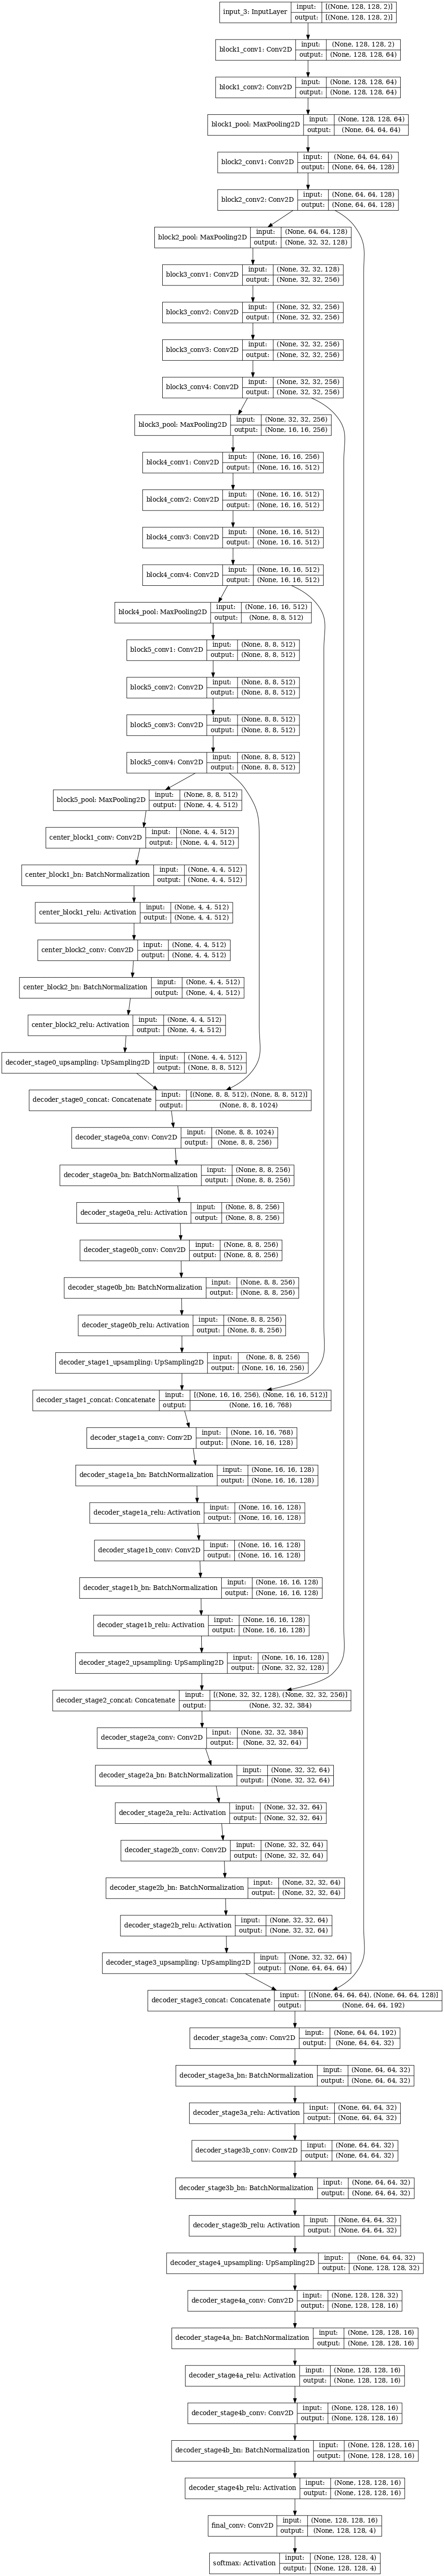

In [61]:
logger = CSVLogger(LOG[CURRENT_MODEL], separator=',', append=False)
callbacks = [
    keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
                                  patience=2, verbose=1, mode='auto'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                      patience=2, min_lr=0.000001, verbose=1),
    ModelCheckpoint(filepath=MODEL[CURRENT_MODEL]),
    logger
]
K.clear_session()

In [62]:
if MODE == 'TRAIN_FRESH' and model is not None:
    history = model.fit(training_generator,
                        epochs=10,
                        steps_per_epoch=len(TRAIN_LIST),
                        callbacks=callbacks,
                        validation_data=val_generator,
                        verbose=1
                        )
    model.save(MODEL[CURRENT_MODEL])
else:
    SAVED_MODEL = {
        'simpleUNET': '../input/cse676-brats-semantic-segmentation/ccrmodels/simpleUNET/simpleUNET.h5',
        'resNETUNET': '../input/cse676-brats-semantic-segmentation/ccrmodels/resnetUNET/resnetUNET.h5',
        'WNET': '../input/cse676-brats-semantic-segmentation/ccrmodels/WNET/WNET.h5',
        'UNETVAE': 'UNETVAE.h5',
        'VGG19': '../input/cse676-brats-semantic-segmentation/ccrmodels/VGG19/VGG19.h5',
        'InceptionV3': '../input/cse676-brats-semantic-segmentation/ccrmodels/InceptionV3/InceptionV3.h5',
        'InceptionResNetV2': '../input/cse676-brats-semantic-segmentation/ccrmodels/InceptionResNetV2/InceptionResNetV2.h5'
    }

    LOG = {
        'simpleUNET': '../input/cse676-brats-semantic-segmentation/ccrmodels/simpleUNET/simpleUNET_training.log',
        'resNETUNET': '../input/cse676-brats-semantic-segmentation/ccrmodels/resnetUNET/resnetUNET_training.log',
        'WNET': '../input/cse676-brats-semantic-segmentation/ccrmodels/WNET/WNET_training.log',
        'UNETVAE': 'UNETVAE_training.log',
        'VGG19': '../input/cse676-brats-semantic-segmentation/ccrmodels/VGG19/VGG19_training.log',
        'InceptionV3': '../input/cse676-brats-semantic-segmentation/ccrmodels/InceptionV3/InceptionV3_training.log',
        'InceptionResNetV2': '../input/cse676-brats-semantic-segmentation/ccrmodels/InceptionResNetV2/InceptionResNetV2_training.log'
    }

    model = keras.models.load_model(SAVED_MODEL[CURRENT_MODEL], custom_objects={
                                    'accuracy': tf.keras.metrics.MeanIoU(num_classes=4)}, compile=False)

In [63]:
def prepare_data_to_predict(path):
    base_path = path
    X = np.empty((SLICES_VOL, IMG_SIZE, IMG_SIZE, 2))
    data = base_path.split('/')[-1]
    data_path = f'{path}/{data}_flair.nii'
    data_path2 = f'{path}/{data}_t1ce.nii'
    data_path3 = f'{path}/{data}_seg.nii'
    flair = nib.load(data_path).get_fdata()
    mask = nib.load(data_path3).get_fdata()
    ce = nib.load(data_path2).get_fdata()
    for j in range(SLICES_VOL):
        X[j, :, :, 0] = cv2.resize(
            flair[:, :, j + VOL_START], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(
            ce[:, :, j + VOL_START], (IMG_SIZE, IMG_SIZE))
    return X, flair, mask

4/4 [==============================] - 28s 6s/step


<Figure size 1800x5000 with 0 Axes>

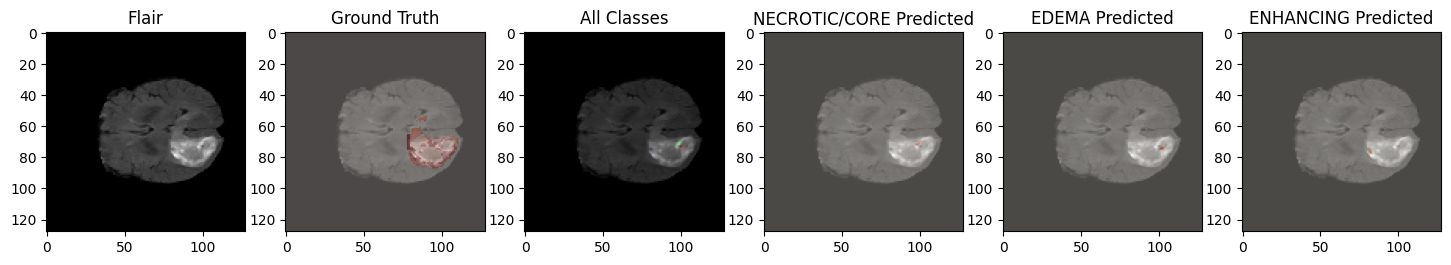

4/4 [==============================] - 26s 6s/step


<Figure size 1800x5000 with 0 Axes>

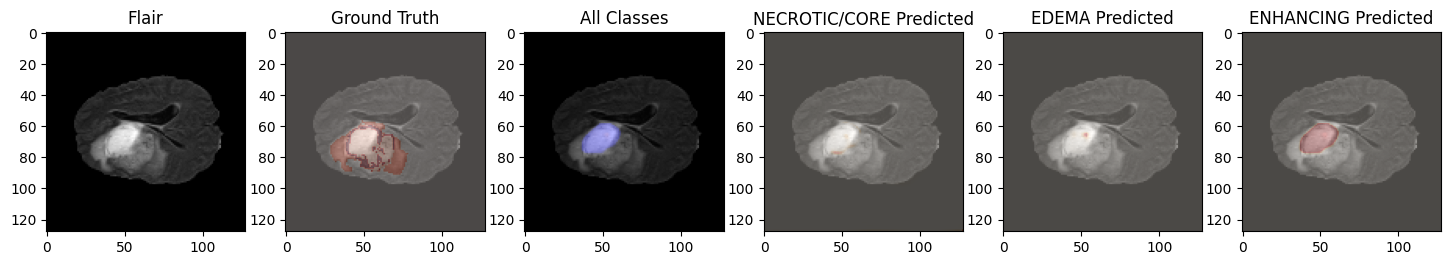

4/4 [==============================] - 37s 9s/step


<Figure size 1800x5000 with 0 Axes>

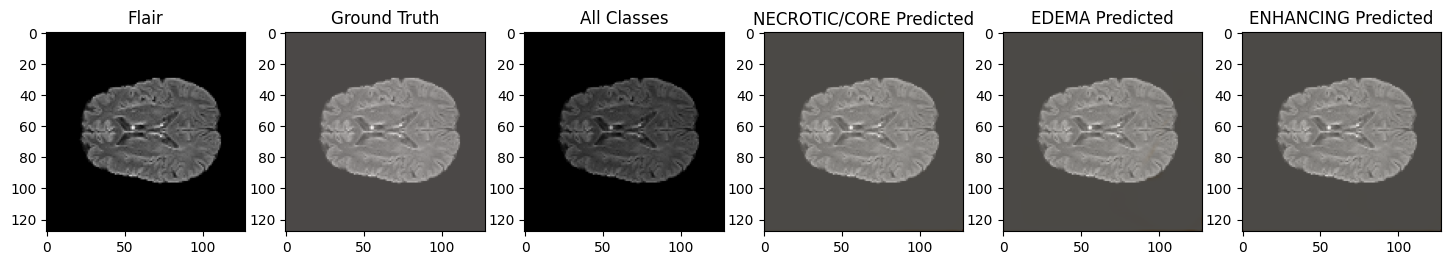

4/4 [==============================] - 27s 6s/step


<Figure size 1800x5000 with 0 Axes>

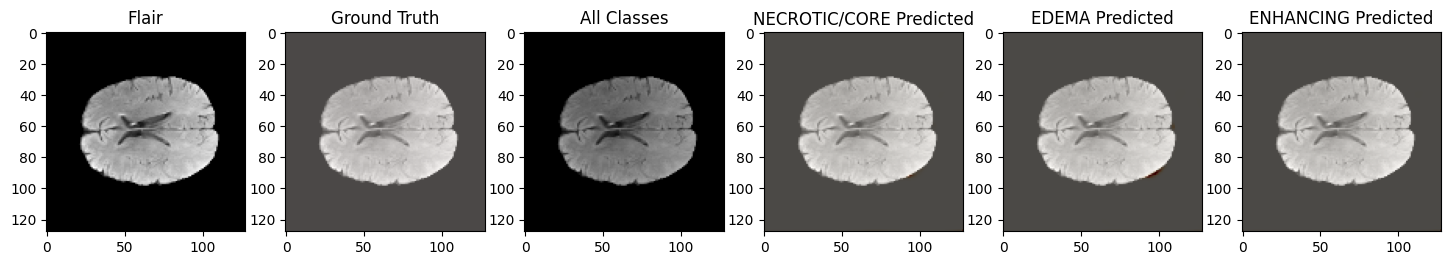

4/4 [==============================] - 36s 9s/step


<Figure size 1800x5000 with 0 Axes>

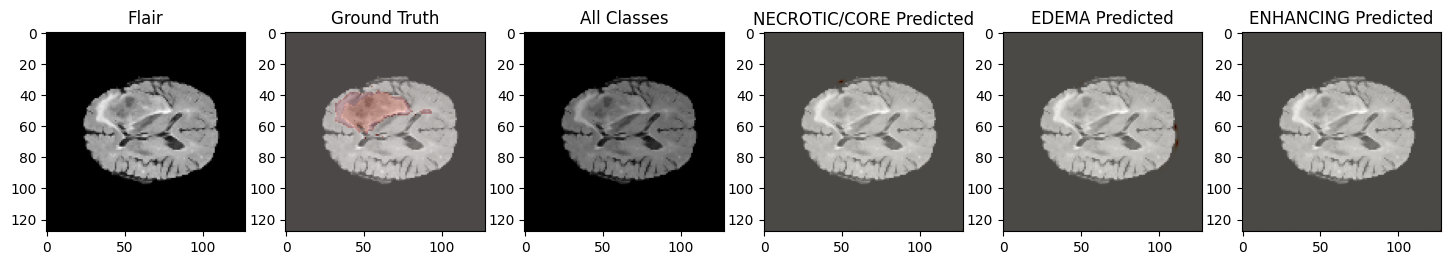

In [64]:
slice = 60


def view_predicted_data(index):
    data, image, gt = prepare_data_to_predict(TEST_LIST[index])
    p = model.predict(data/np.max(data), verbose=1)
    core = p[:, :, :, 1]
    edema = p[:, :, :, 2]
    enhancing = p[:, :, :, 3]
    plt.figure(figsize=(18, 50))
    f, axis_arr = plt.subplots(1, 6, figsize=(18, 50))
    for i in range(6):
        axis_arr[i].imshow(cv2.resize(image[:, :, slice + VOL_START],
                                      (IMG_SIZE, IMG_SIZE)), cmap="gray")

    axis_arr[0].imshow(cv2.resize(image[:, :, slice +
                                        VOL_START], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axis_arr[0].title.set_text('Flair')
    curr_gt = cv2.resize(gt[:, :, slice + VOL_START],
                         (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    axis_arr[1].imshow(curr_gt, cmap="Reds", alpha=0.3)
    axis_arr[1].title.set_text('Ground Truth')
    axis_arr[2].imshow(p[slice, :, :, 1:4], cmap="Reds", alpha=0.3)
    axis_arr[2].title.set_text('All Classes')
    axis_arr[3].imshow(edema[slice, :, :], cmap="OrRd", alpha=0.3)
    axis_arr[3].title.set_text(f'{SEGMENT_CLASSES[1]} Predicted')
    axis_arr[4].imshow(core[slice, :, ], cmap="OrRd", alpha=0.3)
    axis_arr[4].title.set_text(f'{SEGMENT_CLASSES[2]} Predicted')
    axis_arr[5].imshow(enhancing[slice, :, ], cmap="OrRd", alpha=0.3)
    axis_arr[5].title.set_text(f'{SEGMENT_CLASSES[3]} Predicted')
    plt.show()


random_index = random.sample(range(len(TEST_LIST)), 5)
for i in random_index:
    view_predicted_data(i)

4/4 [==============================] - 27s 6s/step


<Figure size 640x480 with 0 Axes>

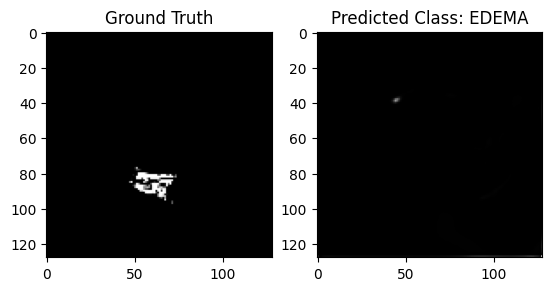

In [65]:
path = random_index[-3]
base_path = TEST_LIST[path]
data, x, gt = prepare_data_to_predict(base_path)
p = model.predict(data/np.max(data), verbose=1)
core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]
i = 40
eval_class = 2
gt[gt != eval_class] = 1
resized_gt = cv2.resize(gt[:,:,i + VOL_START], (IMG_SIZE, IMG_SIZE))
plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('Ground Truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'Predicted Class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

In [67]:
def show_images(epochs, data, label):
    plt.figure()
    f, axarr = plt.subplots(1,2, figsize=(12,4))
    axarr[0].plot(epochs, data[0], 'y', label=f'Training {label[1]}')
    axarr[0].plot(epochs, data[1], 'r', label=f'Validation {label[1]}')
    axarr[0].set_title(f'Training and validation {label[1]}')
    axarr[0].set_xlabel(label[0])
    axarr[0].set_ylabel(label[1])
    axarr[0].legend()

    axarr[1].plot(epochs, data[2], 'y', label=f'Training {label[2]}')
    axarr[1].plot(epochs, data[3], 'r', label=f'Validation {label[2]}')
    axarr[1].set_title(f'Training and validation {label[2]}')
    axarr[1].set_xlabel(label[0])
    axarr[1].set_ylabel(label[2])
    axarr[1].legend()
    plt.show()

<Figure size 640x480 with 0 Axes>

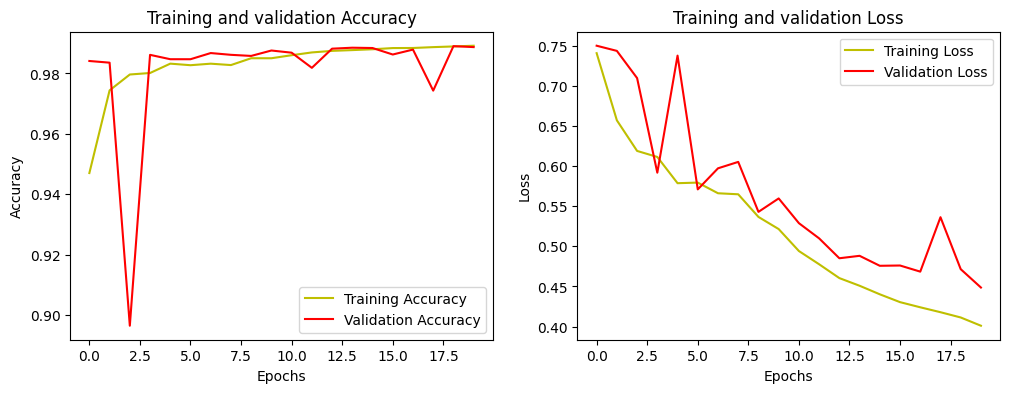

In [68]:
import pandas as pd
history = pd.read_csv(LOG[CURRENT_MODEL], sep=',', engine='python')
n = history['epoch']
hist = history
acc=hist['accuracy']
val_acc=hist['val_accuracy']
loss=hist['loss']
val_loss=hist['val_loss']
show_images(n, [acc, val_acc, loss, val_loss], ['Epochs', 'Accuracy', 'Loss'])